# Algorithm to optimize phase mask

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
% matplotlib inline

C:\Python34\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Utilities

In [2]:
def myfft2(wave_in):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(wave_in)))

def myifft2(wave_in):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(wave_in)))

def cart2pol(x,y):
    """
    Takes cartesian (2D) coordinates and transforms them into polar.
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def PolarTransform(t, rstep, thetastep_deg):
    N = np.shape(t)[0]
    center = N/2+ 1
    thetastep = thetastep_deg*np.pi/180
    polartrans = np.zeros((int(N/2/rstep), int(360/thetastep_deg)), dtype=np.complex)
    
    rs = np.linspace(0,N/2, int(N/2/rstep), endpoint=False)
    qs = np.linspace(0,2*np.pi, int(2*np.pi/thetastep), endpoint=False)
    Rs, Qs = np.meshgrid(rs, qs)
    
    Ylocs = center + Rs*np.sin(Qs)
    Xlocs = center + Rs*np.cos(Qs)
    Xlocs[Xlocs==N]=N-1
    Ylocs[Ylocs==N]=N-1
    for i in np.arange(0,len(rs)):
        for j in np.arange(0,len(qs)):
            polartrans[i,j] = t[Ylocs[j,i], Xlocs[j,i]]
            
    return polartrans

def iPolarTransform(im, rstep_pix, thetastep_deg):
    num_radii, num_angles = np.shape(im)
    N = int(2*num_radii*rstep_pix)
    ipolartrans_real = np.zeros((N,N),dtype=np.complex)
    ipolartrans_imag = np.zeros((N,N), dtype=np.complex)
    ix = np.arange(-N/2, N/2)
    X, Y = np.meshgrid(ix, ix)
    
    R_i = np.round(np.sqrt(X**2+Y**2)/rstep_pix)+ 1
    Q_i = np.round((np.arctan(Y, X)+np.pi)*180/np.pi/thetastep_deg)+1
    Q_i[Q_i == num_angles] = 1
    R_i[R_i>= num_radii]=1
    
    in_real = np.real(im)
    in_imag = np.imag(im)
    for k in np.arange(0, len(ix)):
        for p in np.arange(0, len(ix)):
            ipolartrans_real[k,p] = in_real[R_i[k,p],Q_i[k,p]]
            ipolartrans_imag[k,p] = in_imag[R_i[k,p],Q_i[k,p]]
    
    ipolartrans = ipolartrans_real + 1j*ipolartrans_imag
    ipolartrans[R_i > num_radii] = 0
    ipolartrans = np.rot90(ipolartrans,2)  
    return ipolartrans
                                            
    

## Algorithm

In [3]:
def calcMask(EP, FPMinit, LS, OPT_REG_FP, OPT_REG_LP, max_its, goal_leak):
    """
    Calculates an optimized mask starting from a vortex, for a given entrance pupil EP
    :param EP: Entrance pupil given on a NxN grid axis 0,0
    :param FPMinit: initial focal plane mask
    :param LS: Lyot stop mask
    :param OPT_REG_FP:
    :param OPT_REG_LP:
    :param max_its: max number of iterations
    :goal_leak: fraction of leaked light desirable in the end
    """
    PSF = myfft2(EP) # field at focal plane
    FP = PSF*FPMinit # field just after initial focal plane mask
    
    count = 0  # counter for iterations
    leaks = []  #array to store leak at each iteration
    leak = 1 # intialize leak to 1
    maxleak = np.sum(np.sum(abs(EP*LS)**2))
    
    while(count < max_its and leak > goal_leak):
        count += 1
        LPj = myifft2(FP)  # field in Lyot plane
        LPj *= (1-OPT_REG_LP) # field in LP with nodal region set to zero
        FPj = myfft2(LPj) # current focal plane
        FPC = np.exp(1j*OPT_REG_FP*(np.angle(FPj) - np.angle(PSF) - np.angle(FPMinit)))
        
        leak = np.sum(np.sum(np.real(LPj*LS))**2)/maxleak
        FP = PSF*FPMinit*FPC  # current phase mask, updated focal plane
        leaks.append(leak)
        
    del FPj
    del LPj
    its = count  # final count
    FPM = np.exp(1j*(np.angle(FP)-np.angle(PSF)))
    FPC = np.exp(1j*(np.angle(FP)-np.angle(PSF) - np.angle(FPMinit)))
    finalleak = leak
    return FPM, FPC, its, finalleak
    
    
    

In [4]:
# with circular symmetry enforced
def calcMask_forcesymmetry(EP, FPMinit, LS, OPT_REG_FP, OPT_REG_LP, max_its, goal_leak):
    """
    Calculates an optimized mask starting from a vortex, for a given entrance pupil EP
    :param EP: Entrance pupil given on a NxN grid axis 0,0
    :param FPMinit: initial focal plane mask
    :param LS: Lyot stop mask
    :param OPT_REG_FP:
    :param OPT_REG_LP:
    :param max_its: max number of iterations
    :goal_leak: fraction of leaked light desirable in the end
    """
    every = 10
    
    PSF = myfft2(EP) # field at focal plane
    FP = PSF*FPMinit # field just after initial focal plane mask
    
    count = 0  # counter for iterations
    leaks = []  #array to store leak at each iteration
    leak2 = 1 # intialize leak to 1
    maxleak = np.sum(np.sum(abs(EP*LS)**2))
    
    while(count < max_its and leak2 > goal_leak):
        count += 1
        LPj = myifft2(FP)  # field in Lyot plane
        LPj *= (1-OPT_REG_LP) # field in LP with nodal region set to zero
        FPj = myfft2(LPj) # current focal plane
        
        FPC0 = np.exp(1j*(np.angle(FPj) - np.angle(PSF) - np.angle(FPMinit)))
        leak = np.sum(np.sum(np.real(LPj*LS))**2)/maxleak
        
        if count % every == 0:
            pc_FPC = PolarTransform(FPC0, 1, 1)
            ftpc_FPC = np.fft.fftshift(np.fft.fft(np.fft.fftshift(pc_FPC,axes=(1,)),axis=1),axes=(1,))
            ftpc_FPC_new = np.zeros(np.shape(ftpc_FPC), dtype=np.complex)

            ftpc_FPC_new[:,180] = ftpc_FPC[:,180]

            pc_FPC = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(ftpc_FPC_new,axes=(1,)),axis=1),axes=(1,))
            FPC0 = iPolarTransform(pc_FPC,1,1)
            
        if count % every == 0:
            leak2 = np.sum(np.sum(abs(LPj*LS)**2))/maxleak
                                    
            
        FPC = np.exp(1j*OPT_REG_FP*np.angle(FPC0)) 
        
        FP = PSF*FPMinit*FPC  # current phase mask, updated focal plane
        leaks.append(leak)
        
    del FPj
    del LPj
    its = count  # final count
    FPM = np.exp(1j*(np.angle(FP)-np.angle(PSF)))
    FPC = np.exp(1j*(np.angle(FP)-np.angle(PSF) - np.angle(FPMinit)))
    finalleak = leak
    plt.plot(np.arange(len(leaks)), leaks)
    return FPM, FPC, its, finalleak

## Main

In [56]:
N = 2048
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)

RHO, THETA = cart2pol(X,Y)

apRad = 250
lambdaOverD = N/apRad/2

In [57]:
# choose entrance pupil 
#EP = fits.getdata('VLT_pupil_N=512_apRad_250.0.fits')
from pupil_masks import make_annular_pupil
EP = make_annular_pupil(1024, 250, 0.2)
EP = np.lib.pad(EP, (512, 512), 'constant', constant_values=(0,0))
FPM_init = np.exp(1j*2*THETA)
FP = myfft2(EP)*FPM_init
LP = myifft2(FP)
plt.imshow(abs(EP), interpolation='nearest', cmap='gray', vmin=0, vmax=1)
plt.colorbar()

C:\Users\Chronis\Documents\Ambizione Project\Master project\pyNodal\pupil_masks.py:80: RuntimeWarning: overflow encountered in power
  ANpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


MemoryError: 

In [55]:
### DEBUG
PSF = myfft2(EP)
FP = PSF*FPM_init
maxleak = np.sum(np.sum(abs(EP*LS)**2))

LPj = myifft2(FP)  # field in Lyot plane
LPj *= (1-OPT_REG_LP) # field in LP with nodal region set to zero
FPj = myfft2(LPj) # current focal plane
FPC0 = np.exp(1j*(np.angle(FPj) - np.angle(PSF) - np.angle(FPM_init)))
leak = np.sum(np.sum(np.real(LPj*LS))**2)/maxleak
pc_FPC = PolarTransform(FPC0, 1, 1)
ftpc_FPC = np.fft.fftshift(np.fft.fft(np.fft.fftshift(pc_FPC,axes=(1,)),axis=1),axes=(1,))
ftpc_FPC_new = np.zeros(np.shape(ftpc_FPC), dtype=np.complex)

ftpc_FPC_new[:,180] = ftpc_FPC[:,180]

pc_FPC = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(ftpc_FPC_new,axes=(1,)),axis=1),axes=(1,))
FPC0 = iPolarTransform(pc_FPC,1,1)

C:\Python34\lib\site-packages\ipykernel\__main__.py:31: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python34\lib\site-packages\ipykernel\__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(512, 512)


C:\Python34\lib\site-packages\ipykernel\__main__.py:53: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


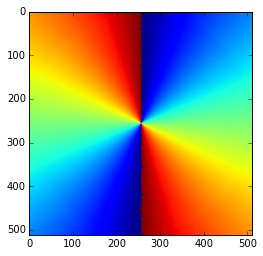

In [60]:
FPC = np.exp(1j*OPT_REG_FP*np.angle(FPC0)) 
FP = PSF*FPM_init*FPC
FPM = np.exp(1j*(np.angle(FP)-np.angle(PSF)))
plt.imshow(np.angle(FPM))

C:\Python34\lib\site-packages\ipykernel\__main__.py:31: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python34\lib\site-packages\ipykernel\__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python34\lib\site-packages\ipykernel\__main__.py:53: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


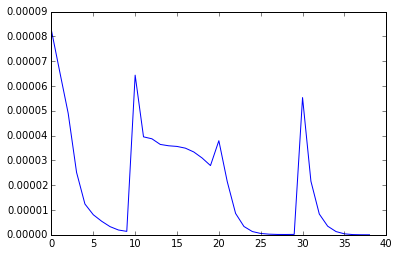

In [39]:
#EP = np.lib.pad(EP, (256, 256), 'constant', constant_values=(0,0))
normI = np.max(np.max(abs(myfft2(EP))**2))  # Irradiance normalization

charge = 2
FPM_init = np.exp(1j*charge*THETA)

OPT_REG_FP = np.ones((N,N))

LS = EP
OPT_REG_LP = EP

max_its = 39
goal_leak = 1e-5
FPM,FPC,its,leak = calcMask_forcesymmetry( EP, FPM_init, LS, OPT_REG_FP, OPT_REG_LP, max_its, goal_leak )


### Optimized Phase Mask (no circular symmetry imposed)

39 4.53483050931e-10


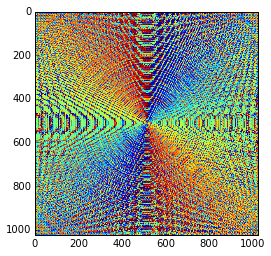

In [40]:
print(its, leak)
plt.imshow(np.angle(FPM))

### Lyot plane of the VLT pupil with Lyot stop and vortex phase mask 

17788360.2622


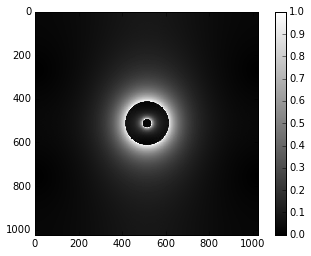

In [53]:
PSF = myfft2(EP)
FP = PSF*FPM_init
LPj = myifft2(FP)
LPj_stop = LPj*LS
plt.imshow(abs(LPj), interpolation='nearest', cmap='gray', vmin=0, vmax=1)
plt.colorbar()
print(np.sum(np.sum(abs(LPj_stop))**2))

### PSF of vortex mask applied for the VLT pupil

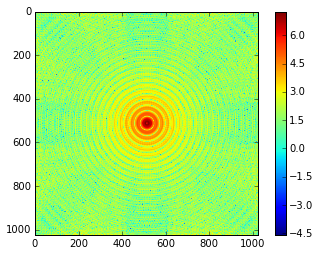

In [12]:
PSF2 = myfft2(LPj_stop)
plt.imshow(np.log(abs(PSF2)))
plt.colorbar()

### Lyot plane  of the VLT pupil with Lyot stop and optimized phase mask 

0.0457173966632


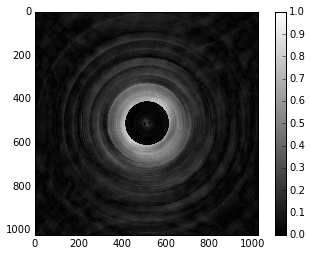

In [52]:
PSF_c = myfft2(EP)
FP_c = PSF_c*FPM
LPj_c = myifft2(FP_c)
LPj_stop_c = LPj_c*LS
plt.imshow(abs(LPj_c),interpolation='nearest', cmap='gray', vmin=0, vmax=1)
plt.colorbar()
print(np.sum(np.sum(abs(LPj_stop_c))**2)/np.sum(np.sum(abs(LPj_stop))**2))

### PSF of the VLT pupil with the opt. mask

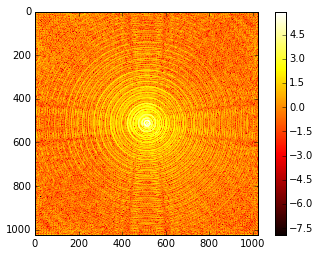

In [51]:
PSF2_c = myfft2(LPj_stop_c)
plt.imshow(np.log(abs(PSF2_c)),interpolation='nearest', cmap='hot')
plt.colorbar()

## Phase mask optimization of FQPM

C:\Users\Chronis\Documents\Ambizione Project\Master project\pyNodal\pupil_masks.py:45: RuntimeWarning: overflow encountered in power
  pupil = np.exp(-np.sqrt((X/a)**2 + (Y/b)**2)**1000)


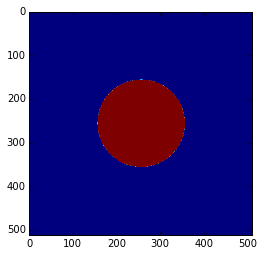

In [3]:
from pupil_masks import make_elliptical_pupil
EP = make_elliptical_pupil(512, 1, 100)
plt.imshow(EP)


In [12]:
pol = PolarTransform(EP, 1, 1)


C:\Python34\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


MemoryError: 

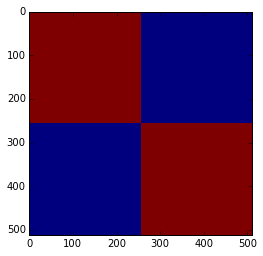

In [11]:
from phase_functions import make_FQPM
FQPM  = make_FQPM(512, 512)
plt.imshow(FQPM)

In [7]:
#EP = np.pad(EP, (256, 256), 'constant', constant_values=(0,0))

(1024, 1024)


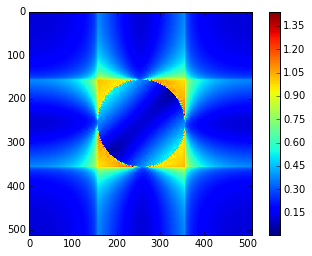

In [12]:
FP = myfft2(EP)*np.exp(1j*np.pi*FQPM)
LP = myifft2(FP)
plt.imshow(abs(LP), interpolation='nearest', cmap='jet')
plt.colorbar()